# Medications Compliance workbook

This workbook uses medication order and statements tables from the NEL primary care data to analyse medications compliance by expolring methods of proportion of days covered (PDC)

See paper https://joppp.biomedcentral.com/articles/10.1186/s40545-021-00385-w

Please check and install requirements.txt before proceeding


## Import required packages/modules

In [1]:
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from tableone import TableOne
from word2number import w2n

from phmlondon.snow_utils import SnowflakeConnection

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)

## CONFIG and FUNCTIONS

In [3]:
def get_top_n_classes(df, column_name, n=10):
    """
    Get the top n most frequent values in a specified column of the dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        column_name (str): The name of the column to analyze.
        n (int): The number of top values to return. Default is 10.

    Returns:
        pd.Series: A series containing the top n most frequent values and their counts.
    """
    return df[column_name].value_counts().head(n)

def plot_top_classes(class_counts):
    """
    Plot the top classes in a bar graph.

    Args:
        class_counts (pd.Series): A series containing the class counts.
    """
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')

    # Set the title and labels
    plt.title('Top Most Frequent Classes', fontsize=16)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to fit everything
    plt.tight_layout()

    # Display the plot
    plt.show()



def clean_dose(df):
    """Cleans the 'dose' column in a given DataFrame.
    Args:
        df: pandas DataFrame with columns called 'dose' and 'quantity'.
    Returns:
        DataFrame with an additional column 'tablets_per_day' and 'calculated_duration' and 'order_enddate'
    """

    def process_dose(dose):
        """Clean the dose column and extract daily tablet count.
        Args:
            dose: A single dose entry (string).
        Returns:
            Calculated tablets per day or None.
        """
        if not isinstance(dose, str):  # Handle cases where dose is NaN or not a string
            return None

        dose = dose.lower().strip()

        # Frequency mapping dictionary
        frequency_mapping = {
            "once": 1,
            "twice": 2,
            "three times": 3,
            "four times": 4,
            "daily": 1,
            "per day": 1,
            "every morning": 1,
            "at night": 1,
            "every evening": 1,
            "morning": 1,
            "night": 1,
            "once a day": 1,
            "twice a day": 2,
            "three times a day": 3,
            "four times a day": 4,
        }

        # Extract frequency first
        frequency_match = None
        for phrase, frequency in frequency_mapping.items():
            if phrase in dose:
                frequency_match = frequency
                break

        if not frequency_match:
            frequency_match = 1  # Default to once daily if no specific frequency found

        # Extract tablet count (defaults to 1 if not found)
        tablet_count = 1  # Default to 1
        tablet_match = re.search(r'(\d+|one|two|three|four|five|six|seven|eight|nine|ten)', dose)
        if tablet_match:
            tablet_count = tablet_match.group(1)
            tablet_count = int(tablet_count) if tablet_count.isdigit() else w2n.word_to_num(tablet_count)

        # Return daily tablets per day
        return tablet_count * frequency_match if frequency_match else None

    # Apply function to "dose" column
    df["tablets_per_day"] = df["dose"].apply(process_dose)

    # Now calculate the "calculated_duration" based on the quantity and tablets_per_day
    df["calculated_duration"] = df.apply(
        lambda row: float(row["quantity_value"]) / row["tablets_per_day"] if (
            row["tablets_per_day"] and row["quantity_unit"] and 
            re.search(r"tablet(s)?|capsule(s)?", row["quantity_unit"], re.IGNORECASE)
        ) else None, axis=1
    )
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

    # Calculate 'order_enddate' by adding 'calculated_duration' or 'duration_days' to 'order_date'
    df["order_enddate"] = df["order_date"] + pd.to_timedelta(df["calculated_duration"].fillna(df["duration_days"]), unit='D')

    return df  # Return modified DataFrame

def compare_durations_summary(comp_orders):
    """
    Compare the 'duration_days' and 'calculated_duration' and flag the most accurate one.

    Arguments:
    comp_orders : DataFrame containing 'duration_days' and 'calculated_duration'

    Returns:
    summary_stats : Dictionary containing summary statistics of the comparisone
    """

    # Calculate absolute difference between documented and calculated duration
    comp_orders['abs_diff'] = (comp_orders['duration_days'] - comp_orders['calculated_duration']).abs()

    # Calculate relative difference (relative to the max of the two values)
    comp_orders['rel_diff'] = comp_orders['abs_diff'] / comp_orders[['duration_days', 'calculated_duration']].max(axis=1)

    # Calculate percentage difference
    comp_orders['perc_diff'] = (comp_orders['abs_diff'] / comp_orders['duration_days']) * 100

    summary_stats = {
        "mean_abs_diff": comp_orders['abs_diff'].mean(),
        "median_abs_diff": comp_orders['abs_diff'].median(),
        "max_abs_diff": comp_orders['abs_diff'].max(),
        "min_abs_diff": comp_orders['abs_diff'].min(),
        "mean_perc_diff": comp_orders['perc_diff'].mean(),
        "median_perc_diff": comp_orders['perc_diff'].median(),
        "max_perc_diff": comp_orders['perc_diff'].max(),
        "min_perc_diff": comp_orders['perc_diff'].min(),
        "count_flag_calculated": (comp_orders['abs_diff'] <= 5).sum(),  # Example flag where abs_diff <= 5
        "count_flag_documented": (comp_orders['abs_diff'] > 5).sum(),  # Example flag where abs_diff > 5
    }

    return summary_stats



def define_treatment_periods(df, gap_threshold=None):
    """
    Assigns period IDs based on treatment gaps.

    Arguments:
        df : DataFrame containing prescription orders.
        gap_threshold : Integer defining treatment gaps (default: uses order-specific duration_days).

    Returns:
        df : Updated DataFrame with 'period_id'.
    """

    date_cols = ["order_date", "order_enddate"]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    # Ensure gap_threshold is numeric
    if gap_threshold is not None:
        df["gap_value"] = gap_threshold
    else:
        df["gap_value"] = pd.to_numeric(df["calculated_duration"].fillna(df["duration_days"]), errors="coerce")

    # Sort & rank orders per Person & Drug
    df = df.sort_values(["person_id", "drug", "order_date"])
    df["order_rank"] = df.groupby(["person_id", "drug"]).cumcount() + 1

    # Compute Days to Next Order
    df["next_order_date"] = df.groupby(["person_id", "drug"])["order_date"].shift(-1)
    df["days_to_next_order"] = (df["next_order_date"] - df["order_enddate"]).dt.days
    df["days_to_next_order"] = df["days_to_next_order"].fillna(0).clip(lower=0)

    # Identify New Treatment Periods
    df["new_period_flag"] = (df["days_to_next_order"] > df["gap_value"]).astype(int)
    df["shifted_flag"] = df.groupby(["person_id", "drug"])["new_period_flag"].shift(1, fill_value=0)
    df["period_id"] = df.groupby(["person_id", "drug"])["shifted_flag"].cumsum() + 1

    # Exclude Last Gap in a Period (Represents Treatment Break)
    df["days_to_next_order"] = df["days_to_next_order"].where(df["new_period_flag"] != 1, 0)

    return df


def period_pdc(df):
    """
    Summarises treatment periods per person and drug and calculates PDC.

    Arguments:
        df : DataFrame with period IDs assigned.

    Returns:
        period_summary : DataFrame summarising each period including a PDC calculation.
    """

    period_summary = df.groupby(["person_id", "drug", "period_id"]).agg(
        start_date=("order_date", "min"),
        end_date=("order_enddate", "max"),
        order_gaps=("days_to_next_order", "sum"),
    ).reset_index()

    period_summary["duration_period"] = (period_summary["end_date"] - period_summary["start_date"]).dt.days

    # Calculate Estimated PDC
    period_summary["duration_orders"] = period_summary["duration_period"] - period_summary["order_gaps"]
    period_summary["est_pdc"] = period_summary["duration_orders"] / period_summary["duration_period"]

    # Avoid division by zero, return NaN instead of None
    period_summary["est_pdc"] = period_summary["est_pdc"].where(period_summary["duration_period"] > 0, float("nan"))

    return period_summary



def preprocess_orders(df):
    """ Fills missing duration values and generates covered days for each order. """
    df['days_supply'] = df['calculated_duration'].fillna(df['duration_days']).fillna(0).astype(int)  # Ensures no NaNs

    # Expand covered days
    df['covered_days'] = df.apply(lambda row: pd.date_range(row['order_date'], periods=row['days_supply']), axis=1)

    # Explode into individual covered days & reset index
    return df.explode('covered_days', ignore_index=True)[['person_id', 'drug', 'covered_days']]

def compute_pdc(df, start_date, end_date):
    """ Computes PDC for a given time window. """
    total_days = (end_date - start_date).days + 1
    covered_days = df[(df['covered_days'] >= start_date) & (df['covered_days'] <= end_date)]['covered_days'].nunique()
    return covered_days / total_days if total_days > 0 else 0

def calculate_moving_pdc(df, window_size='12M', step_size='1M'):
    """ Calculates moving window PDC for all patients & drugs. """
    results = []
    patients_drugs = df[['person_id', 'drug']].drop_duplicates()

    for _, row in patients_drugs.iterrows():
        patient, drug = row['person_id'], row['drug']
        subset = df[(df['person_id'] == patient) & (df['drug'] == drug)]

        # Define time range
        min_date, max_date = subset['covered_days'].min(), subset['covered_days'].max()
        start_dates = pd.date_range(start=min_date, end=max_date, freq=step_size)

        for start in start_dates:
            end = start + pd.DateOffset(months=int(window_size[:-1])) - pd.Timedelta(days=1)
            pdc = compute_pdc(subset, start, end)
            results.append({'person_id': patient, 'drug': drug, 'start_window': start, 'end_window': end, 'PDC': pdc})

    return pd.DataFrame(results)



def plot_pdc_trend(df_patient):
    """
    Plots PDC over time for a patient, showing each drug's trend on the same graph.
    Takes only the patient-specific dataframe.
    """
    # Get the unique drugs for this patient
    unique_drugs = df_patient['drug'].unique()

    # Create the plot
    plt.figure(figsize=(10, 5))

    # Loop through each drug and plot the PDC trend with different colors
    for idx, drug in enumerate(unique_drugs):
        drug_pdc = df_patient[df_patient['drug'] == drug]
        plt.plot(drug_pdc['start_window'], drug_pdc['PDC'], marker='o', linestyle='-', label=drug, color=plt.cm.tab10(idx % 10))  

    # Get the earliest start_date and latest end_date for the patient (across all drugs)
    overall_start_date = df_patient['start_date'].min()
    overall_end_date = df_patient['end_date'].max()

    # Add vertical dashed red lines for start and end dates
    plt.axvline(x=overall_start_date, color='red', linestyle='--', label=f'Start Date: {overall_start_date.date()}')
    plt.axvline(x=overall_end_date, color='red', linestyle='--', label=f'End Date: {overall_end_date.date()}')

    # Title with drug names
    drug_names_str = ', '.join(unique_drugs)  
    plt.title(f'PDC Over Time for Patient {df_patient["person_id"].iloc[0]} - Drugs: {drug_names_str}')

    # Labels and Formatting
    plt.xlabel('Time (Start Window)')
    plt.ylabel('Proportion of Days Covered (PDC)')
    plt.legend(title='Drugs', loc='upper left', bbox_to_anchor=(1,1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def poi_analysis(df, start_poi, end_poi, window_size='12M', step_size='1M'):
    """
    Filters the data based on a given Period of Interest (POI) and computes PDC for that period.

    Parameters:
    - df: The original dataframe containing medication order data.
    - start_poi: Start date of the period of interest (e.g., '2024-01-01').
    - end_poi: End date of the period of interest (e.g., '2024-12-31').
    - window_size: Window size for moving PDC calculation (e.g., '12M').
    - step_size: Step size for the moving window (e.g., '1M').

    Returns:
    - pdc_df: DataFrame with moving window PDC calculations, including first and last order dates for each person_drug combination.
    """

    # Convert start_poi and end_poi to datetime if they are not already
    start_poi = pd.to_datetime(start_poi)
    end_poi = pd.to_datetime(end_poi)

    # Step 1: Preprocess the orders to generate 'covered_days'
    covered_days_df = preprocess_orders(df)

    # Step 2: Filter the data based on the POI
    df_poi = covered_days_df[(covered_days_df['covered_days'] >= start_poi) & (covered_days_df['covered_days'] <= end_poi)]

    # Step 3: Calculate the moving window PDC for the filtered period
    pdc_df = calculate_moving_pdc(df_poi, window_size=window_size, step_size=step_size)

    # Step 4: Get first and last order dates for each person_drug combo
    first_last_order_dates = df.groupby(['person_id', 'drug']).agg(
        start_date=('order_date', 'min'),
        end_date = ('order_enddate', 'max')
    ).reset_index()

    # Step 5: Merge first and last order dates with the PDC data
    pdc_df = pdc_df.merge(first_last_order_dates, on=['person_id', 'drug'], how='left')

    return pdc_df



## DATA

In [4]:
def get_data(snowsesh, class_1, class_2, class_3):
    """
    Retrieves dataset.

    Args:
        snowsesh (object): Database session object for executing queries.
        class_1 (str): First class to filter by.
        class_2 (str): Second class to filter by.
        class_3 (str): Third class to filter by.

    Returns:
        DataFrame: The retrieved dataset.
    """

    chosen_classes = [class_1, class_2, class_3]
    classes_condition = ", ".join(f"'{cls}'" for cls in chosen_classes)

    query = f"""
    SELECT
        o.id AS order_id,
        o.person_id,
        o.medication_statement_id,
        d.order_name AS concept_name,
        c.name,
        d.drug,
        o.dose,
        o.quantity_value,
        o.quantity_unit,
        d.class,
        d.core_concept_id,
        o.core_concept_id AS concept,
        o.clinical_effective_date AS order_date,
        o.duration_days,
        s.clinical_effective_date AS statement_date,
        s.cancellation_date AS statement_enddate
    FROM
        prod_dwh.analyst_primary_care.medication_order o
    LEFT JOIN
        intelligence_dev.ai_centre_dev.drug_table_v3 d
        ON d.core_concept_id = o.core_concept_id
    LEFT JOIN
        prod_dwh.analyst_primary_care.concept c
        ON c.dbid = o.core_concept_id
    LEFT JOIN
        prod_dwh.analyst_primary_care.medication_statement s
        ON s.id = o.medication_statement_id
    WHERE d.class IN ({classes_condition})
    LIMIT 100000;
    """

    try:
        df = snowsesh.execute_query_to_df(query)
        df.columns = df.columns.str.lower()
        print(f"Retrieved {len(df)} rows with columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error retrieving modeling data: {e}")
        raise

def add_demographic_data(snowsesh, df, join_col="person_id"):

    """ Bring in the dempgraphics table and joins to the current table
        Arguments:
                  snowsesh:
                    df = the dataframe oyu want to add demographic data to
                      join_cols = what you ant the join to be on 
      """

    query = """
    SELECT * FROM intelligence_dev.ai_centre_feature_store.person_nel_master_index
    """
    try:
        # Retrieve demographic data
        demo_df = snowsesh.execute_query_to_df(query)
        demo_df.columns = demo_df.columns.str.lower()  # Ensure column names are lowercase

        # Perform left join on person_id
        merged_df = df.merge(demo_df, on=join_col, how="left")

        print(f"Merged data: {len(merged_df)} rows with columns: {list(merged_df.columns)}")
        return merged_df

    except Exception as e:
        print(f"Error retrieving or merging demographic data: {e}")
        raise

def match_closest_compliance_date(df, snowsesh):
    """
    Fetches compliance data from Snowflake and matches each order to the closest compliance date.

    Arguments:
        df : DataFrame with prescription orders, containing 'person_id' and 'order_date'.
        snowsesh : Active Snowflake connection.

    Returns:
        df : Updated with 'closest_compliance_date' and 'medication_compliance'.
    """

    # Fetch compliance data from Snowflake
    query = """
       SELECT DISTINCT person_id,
                clinical_effective_date as compliance_date,
                CASE
                    WHEN core_concept_id = '119686' THEN 'good'
                    WHEN core_concept_id = '239913' THEN 'poor'
                END AS medication_compliance
        FROM prod_dwh.analyst_primary_care.observation
        WHERE core_concept_id IN ('119686', '239913')
        ORDER BY person_id, compliance_date;
    """
    try:
        compliance_df = snowsesh.execute_query_to_df(query)
        compliance_df.columns = compliance_df.columns.str.lower()
        print(f"Retrieved {len(compliance_df)} rows with columns: {list(compliance_df.columns)}")

        # Ensure dates are in datetime format
        df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce")
        compliance_df["compliance_date"] = pd.to_datetime(compliance_df["compliance_date"], errors="coerce")

        # Merge compliance data (many-to-many merge)
        merged_df = df.merge(compliance_df, on="person_id", how="left")

        # Compute the absolute difference between start_date and compliance_date
        merged_df["date_diff"] = (merged_df["start_date"] - merged_df["compliance_date"]).abs()

        # Drop rows with NaN in 'date_diff', since we can't compute the closest date for these
        merged_df = merged_df.dropna(subset=["date_diff"])

        # Find the closest compliance date per order
        closest_compliance = merged_df.loc[merged_df.groupby(["person_id", "start_date"])["date_diff"].idxmin(), 
                                           ["person_id", "start_date", "compliance_date", "medication_compliance"]]

        # Merge back to orders_df
        df = df.merge(closest_compliance, on=["person_id", "start_date"], how="left")

        # Rename for clarity
        df.rename(columns={"compliance_date": "closest_compliance_date"}, inplace=True)

        return df

    except Exception as e:
        print(f"Error retrieving modeling data: {e}")
        raise



## SUMMARY STATS

Table one, stratified by compliance


In [5]:
def get_table_one(df, stratification_col):
    """Creates a journal style 'tableone' with descriptive statistics
    and appropriate tests for stratified data"""

    categorical_vars = ['gender', 'ethnicity', 'imd_quintile', 'smoking_status', 'comorbidities']
    continuous_vars = ['bmi_value', 'est_pdc']

    table1 = TableOne(df, categorical=categorical_vars,
                  continuous=continuous_vars,
                  groupby= stratification_col,
                  pval=True, missing=True)


    print(table1)


## REGRESSION and ANALYSIS

## PIPELINE

In [6]:
load_dotenv()

snowsesh = SnowflakeConnection()
snowsesh.use_database("INTELLIGENCE_DEV")
snowsesh.use_schema("AI_CENTRE_FEATURE_STORE")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJPc9owEMW%2Fikc925aM%2BacBMhRCS5ukTHBopjfZlokGWXK1chz66SsbmEkOySE3jfR2f0%2F7dnL1UkrvmRsQWk0RCTDyuMp0LtR%2Bih6SlT9CHlimcia14lN05ICuZhNgpazovLZP6p7%2FrTlYzzVSQNuHKaqNopqBAKpYyYHajG7ntzc0CjBlANxYh0PnkhyEYz1ZW9EwbJomaHqBNvswwhiHeBw6VSv5gl4hqo8ZldFWZ1peSl7cn95BkBDHLcIpHGFzLvwq1GkEH1HSkwjo9yTZ%2BJtf2wR588vvFlpBXXKz5eZZZPzh%2FuZkAJyD7XV%2FQEaDoD74oN0MA%2FavNjwApZtCsgPPdFnV1rUO3CkseB5KvRduYOvlFFUHkQ%2FVTv2A9NuGjB7h8ViKwd3P0fWySgB2kgx%2Fk9WQL%2BN5b7u4zZC3u8QbtfGuAWq%2BVm2o1l3hqO%2Fj2CfDhGCKezSKA9LHf5C3dKEKxWxXeXHe%2BQhKkRkNurBaSaF453KEh4O4N878fkoKP%2Bak748JZz7DaVHgtJcWZBC20UXotD60M2JmnxrKJHzd4ryOdy6h9XKjpciO3kqbktn3AyQB6W5E7hedlPKSCTnPc8MBXJBS6mZhOLNu662pOQpnJ%

### Table with estimated PD per period. 

Period is defined by duration threshold.
One row per period


In [7]:
df = get_data(snowsesh,'Lipid-regulating drugs', 'Calcium-channel blockers','Angiotensin-converting enzyme inhibitors')
df.head()
#df.groupby(['person_id', 'drug']).size().reset_index(name='count').shape[0]

Retrieved 100000 rows with columns: ['order_id', 'person_id', 'medication_statement_id', 'concept_name', 'name', 'drug', 'dose', 'quantity_value', 'quantity_unit', 'class', 'core_concept_id', 'concept', 'order_date', 'duration_days', 'statement_date', 'statement_enddate']


,order_id,person_id,medication_statement_id,concept_name,name,drug,dose,quantity_value,quantity_unit,class,core_concept_id,concept,order_date,duration_days,statement_date,statement_enddate
0,55083665,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2013-05-17,0,2013-05-17,2015-03-30
1,55083597,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2013-07-26,0,2013-05-17,2015-03-30
2,55083672,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2014-12-01,0,2013-05-17,2015-03-30
3,55083658,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2015-03-30,0,2013-05-17,2015-03-30
4,55083711,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2014-06-30,0,2013-05-17,2015-03-30


class
Lipid-regulating drugs                      46802
Calcium-channel blockers                    28177
Angiotensin-converting enzyme inhibitors    25021
Name: count, dtype: int64


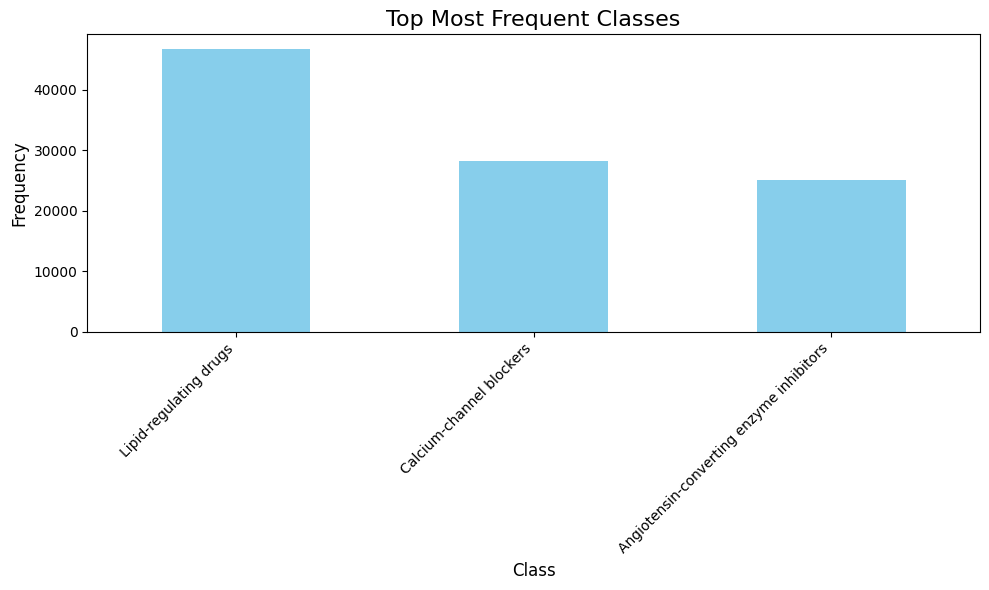

In [8]:
top_3_classes = get_top_n_classes(df, 'class', n=3)

print(top_3_classes.head())

plot_top_classes(top_3_classes)

In [9]:
clean_df = clean_dose(df)
clean_df.head()

#clean_df[clean_df['tablets_per_day'] != 1][['dose', 'quantity_value', 'duration_days', 'calculated_duration', 'tablets_per_day']].head(100)
#clean_df[clean_df['duration_days'] != clean_df['calculated_duration']][['dose', 'order_date', 'quantity_value', 'duration_days', 'calculated_duration', 'tablets_per_day']].head(100)

,order_id,person_id,medication_statement_id,concept_name,name,drug,dose,quantity_value,quantity_unit,class,core_concept_id,concept,order_date,duration_days,statement_date,statement_enddate,tablets_per_day,calculated_duration,order_enddate
0,55083665,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2013-05-17,0,2013-05-17,2015-03-30,1.0,84.0,2013-08-09
1,55083597,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2013-07-26,0,2013-05-17,2015-03-30,1.0,84.0,2013-10-18
2,55083672,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2014-12-01,0,2013-05-17,2015-03-30,1.0,84.0,2015-02-23
3,55083658,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2015-03-30,0,2013-05-17,2015-03-30,1.0,84.0,2015-06-22
4,55083711,84413,55083543.0,Product containing precisely atorvastatin 10 m...,Product containing precisely atorvastatin 10 m...,Atorvastatin,1 TABLET ONCE A DAY,84.00,tablet,Lipid-regulating drugs,212026,212026,2014-06-30,0,2013-05-17,2015-03-30,1.0,84.0,2014-09-22


In [18]:
compare_durations_summary(clean_df)

{'mean_abs_diff': np.float64(22.76618436406479),
 'median_abs_diff': np.float64(0.0),
 'max_abs_diff': np.float64(39867.0),
 'min_abs_diff': np.float64(0.0),
 'mean_perc_diff': np.float64(inf),
 'median_perc_diff': np.float64(0.0),
 'max_perc_diff': np.float64(inf),
 'min_perc_diff': np.float64(-100.14153208481815),
 'count_flag_calculated': np.int64(63336),
 'count_flag_documented': np.int64(34344)}

Need to sort the clean dose code and add the duration days calculation into the pipe

In [19]:
period_data = define_treatment_periods(clean_df, gap_threshold=365)
pdc_data = period_pdc(period_data)





In [20]:
print(period_data.head)

<bound method NDFrame.head of          order_id  person_id  medication_statement_id  \
30489       58501         26             5.743700e+04   
30488       59371         26             5.743700e+04   
30491       58745         26             5.743700e+04   
30487       58613         26             5.743700e+04   
30490       59134         26             5.743700e+04   
...           ...        ...                      ...   
16463  5911885101    6419196             5.911885e+09   
62140  5913264642    6419518             5.913264e+09   
83350  5989223610    6433461             5.989224e+09   
27202  6015987697    6444302             6.015988e+09   
30800  6163950174    6460155             6.163950e+09   

                                            concept_name  \
30489  Product containing precisely pravastatin sodiu...   
30488  Product containing precisely pravastatin sodiu...   
30491  Product containing precisely pravastatin sodiu...   
30487  Product containing precisely pravastat

In [21]:
print(pdc_data.head)

<bound method NDFrame.head of        person_id                       drug  period_id start_date   end_date  \
0             26         Pravastatin sodium          1 2013-10-16 2014-02-21   
1             51                   Ramipril          1 2006-05-15 2007-02-09   
2             61                 Nifedipine          1 2002-11-04 2003-10-13   
3             67  Simvastatin and ezetimibe          1 2008-07-14 2008-10-14   
4             72       Perindopril erbumine          1 2014-04-04 2014-07-29   
...          ...                        ...        ...        ...        ...   
10510    6419196          Enalapril maleate          1 1995-03-28 1995-03-29   
10511    6419518                  Captopril          1 1995-10-19 1995-10-20   
10512    6433461                 Amlodipine          1 2016-02-13 2016-03-12   
10513    6444302                   Ramipril          1 2025-02-04 2025-03-04   
10514    6460155                 Amlodipine          1 2007-12-19 2008-01-16   

       or

Add demographic data to the table

In [22]:
pdc_demo_data = add_demographic_data(snowsesh, pdc_data)
pdc_demo_comp_data = match_closest_compliance_date(pdc_demo_data, snowsesh)
pdc_demo_data.groupby(['person_id', 'drug']).size().reset_index(name='count').shape[0]
pdc_demo_comp_data.groupby(['person_id', 'drug']).size().reset_index(name='count').shape[0]



Merged data: 10515 rows with columns: ['person_id', 'drug', 'period_id', 'start_date', 'end_date', 'order_gaps', 'duration_period', 'duration_orders', 'est_pdc', 'start_of_month', 'end_of_month', 'practice_code', 'practice_name', 'registration_start_date', 'registration_end_date', 'include_in_list_size_flag', 'gender', 'ethnicity', 'ethnicity_detail', 'ethnicity_main_category', 'ethnic_aic_category', 'patient_lsoa_2011', 'patient_lsoa_2021', 'imd_decile', 'imd_quintile', 'date_of_death_pmi', 'date_of_death_dataset', 'uprn_suggests_lives_alone_flag', 'smoking_status', 'latest_smoking_status_date', 'ever_homeless_flag', 'housebound_flag', 'housebound_type', 'latest_housebound_code_date', 'obesity_flag', 'latest_bmi_date', 'bmi_value', 'total_ltcs', 'comorbidities', 'asthma', 'atrial_fibrillation', 'cancer', 'chronic_kidney_disease', 'copd', 'coronary_heart_disease', 'dementia', 'depression', 'diabetes', 'diabetes_type_1', 'diabetes_type_2_other', 'epilepsy', 'heart_failure', 'hypertensio

10296

In [23]:
# Check for duplicates in the key columns
print(pdc_demo_data[['person_id', 'drug']].duplicated().sum())  # In the first dataset
print(pdc_demo_comp_data[['person_id', 'drug']].duplicated().sum())  # In the second dataset

219
219


In [24]:
print(pdc_demo_comp_data.describe(include='all'))

           person_id        drug     period_id                     start_date  \
count   1.051500e+04       10515  10515.000000                          10515   
unique           NaN          45           NaN                            NaN   
top              NaN  Amlodipine           NaN                            NaN   
freq             NaN        2102           NaN                            NaN   
mean    1.355452e+06         NaN      1.023585  2012-06-03 09:55:59.657631744   
min     2.600000e+01         NaN      1.000000            1970-01-04 00:00:00   
25%     3.387905e+05         NaN      1.000000            2007-12-05 00:00:00   
50%     8.254250e+05         NaN      1.000000            2012-10-05 00:00:00   
75%     2.169980e+06         NaN      1.000000            2017-02-16 12:00:00   
max     6.460155e+06         NaN      6.000000            2025-03-14 00:00:00   
std     1.301370e+06         NaN      0.176127                            NaN   

                           

In [25]:
get_table_one(pdc_demo_comp_data,'medication_compliance')

                                                 Grouped by medication_compliance                                                            
                                                                          Missing          Overall             good              poor P-Value
n                                                                                            10515             2491               286        
est_pdc, mean (SD)                                                            814        0.9 (0.2)        0.9 (0.2)         0.8 (0.2)  <0.001
gender, n (%)         Female                                                           4630 (44.0)      1231 (49.4)        137 (47.9)   0.841
                      Male                                                             4627 (44.0)      1192 (47.9)        140 (49.0)        
                      None                                                             1256 (11.9)         68 (2.7)           9 (3.1)        
ethnic

## PDC moving window

        order_id  person_id  medication_statement_id  \
76088  432886585         51              432886405.0   
76089  432886963         51              432886405.0   
76090  432887199         51              432886405.0   
76091  432886827         51              432886405.0   
76092  432886756         51              432886405.0   

                                            concept_name  \
76088  Product containing precisely ramipril 1.25 mil...   
76089  Product containing precisely ramipril 1.25 mil...   
76090  Product containing precisely ramipril 1.25 mil...   
76091  Product containing precisely ramipril 1.25 mil...   
76092  Product containing precisely ramipril 1.25 mil...   

                                                    name      drug  \
76088  Product containing precisely ramipril 1.25 mil...  Ramipril   
76089  Product containing precisely ramipril 1.25 mil...  Ramipril   
76090  Product containing precisely ramipril 1.25 mil...  Ramipril   
76091  Product contain

/var/folders/2t/xl_j0_m160l644q0w8nh34zh0000gn/T/ipykernel_90557/2861875367.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_supply'] = df['calculated_duration'].fillna(df['duration_days']).fillna(0).astype(int)  # Ensures no NaNs
/var/folders/2t/xl_j0_m160l644q0w8nh34zh0000gn/T/ipykernel_90557/2861875367.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['covered_days'] = df.apply(lambda row: pd.date_range(row['order_date'], periods=row['days_supply']), axis=1)


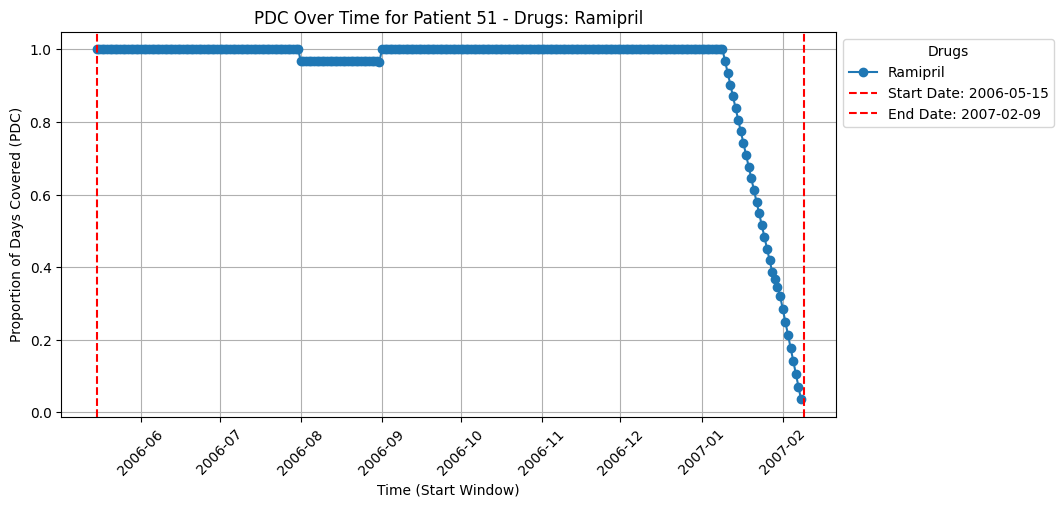

In [15]:
# Define your Period of Interest (POI)
start_poi = '2006-01-01'
end_poi = '2007-12-31'


# Filter the data for a specific patient (e.g., patient with person_id = 6387610)
patient_data = clean_df[clean_df['person_id'] == 51]
print(patient_data.head())

# Run the POI analysis for just this patient
pdc_df_patient = poi_analysis(patient_data, start_poi=start_poi, end_poi=end_poi, window_size='1M', step_size='1D')
print(pdc_df_patient.head())


# Plot the PDC trend for this specific patient and drug
plot_pdc_trend(pdc_df_patient)
